# pyphysio tutorial

## 2. Algorithms

In this second tutorial we will see how to use the class `Algorithm` to create signal processing pipelines.


A signal processing step is a computational function $F$ that operates on input data (a signal) to produce a result. It is characterized by a set of parameters **p** which regulate its behavior.

![algorithm](img/algorithm.png)

*Figure 1: Abstract representation of a processing step.*

1. In pyphysio each processing step is represented by an instance of a class derived from the generic class `Algorithm`.

2. The type of function or algorithm is given by the class name (e.g. `BeatFromECG` extracts the heartbeats from an ECG signal, `PeakDetection` detects the peaks in the input signal).

3. The parameters of the function/algorithm are the attributes of the created instance.

Therefore, a processing step is defined by creating a new instance of the Class, which is initialized with the given parameters:
```
processing_step = ph.BeatFromECG(parameters)
```
To execute the processing step we need to give as input an instance of the class `Signal`:
```
output = processing_step(input)
```


Algorithms in pyphysio are grouped in four categories (see also the tutorial '3-pipelines'):

* Filters : deterministic algorithms that modify the values of the input signal without changing its nature;
* Estimators : algorithms that aim at extracting information from the input signal which is given in output as a signal with a different nature;
* Indicators : algorithms that operate on the signal to provide a scalar value (or metrics)
* Tools : algorithms that can be useful for the signal processing and return as output one or more numpy arrays or scalars.

In [1]:
# import packages
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# import data from included examples
from pyphysio.tests import TestData
from pyphysio import EvenlySignal

ecg_data = TestData.ecg()
eda_data = TestData.eda()

# create two signals
fsamp = 2048
tstart_ecg = 15
tstart_eda = 5

ecg = EvenlySignal(values = ecg_data, 
                   sampling_freq = fsamp, 
                   signal_type = 'ecg', 
                   start_time = tstart_ecg)

eda = EvenlySignal(values = eda_data, 
                   sampling_freq = fsamp, 
                   signal_type = 'eda', 
                   start_time = tstart_eda)

### 2.1 Filters

Filters return a signal which has the same **`signal_nature`** of the input signal. 

The name *`Filters`* recalls the aim of this algorithms which is in general to increase the Signal/Noise ratio by filtering out the unwanted components in a signal (e.g high frequency noise).

In [2]:
# create a Filter
import pyphysio.filters.Filters as flt

lowpass_50 = flt.IIRFilter(fp=50, fs=75, ftype='ellip')

In [3]:
# help inline
#?flt.IIRFilter

In [4]:
# check parameters
print(lowpass_50)
# OR
print(lowpass_50.get())

IIRFilter{'fp': 50, 'fs': 75, 'loss': 0.1, 'att': 40, 'ftype': 'ellip'}
{'fp': 50, 'fs': 75, 'loss': 0.1, 'att': 40, 'ftype': 'ellip'}


In [5]:
# apply a Filter
ecg_filtered = lowpass_50(ecg)

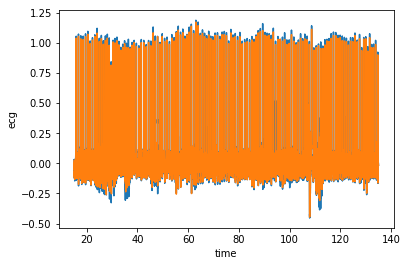

In [6]:
#plot
ecg.plot()
ecg_filtered.plot()

In [7]:
# check output type
ecg.get_signal_type()

'ecg'

### 2.2 Estimators
Estimators are algorithms which aim at extracting the information of interest from the input signal, thus returning a new signal which has a different **`signal_nature`**. 

The name *`Estimators`* recalls the fact that the information extraction depends on the value of the algorithm parameters which might not be known *a-priori*. Thus the result should be considered as an estimate of the real content of information of the input signal.

In [8]:
# create an Estimator
import pyphysio.estimators.Estimators as est

ibi_ecg = est.BeatFromECG()

In [9]:
# check parameters
ibi_ecg

BeatFromECG{'bpm_max': 120, 'delta': 0, 'k': 0.7}

In [10]:
# apply an Estimator
ibi = ibi_ecg(ecg_filtered)

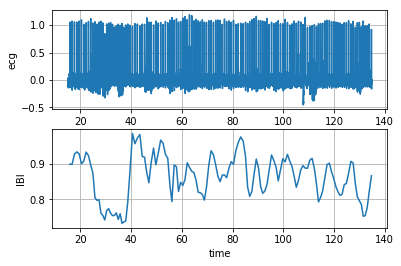

In [11]:
# plot
ax1 = plt.subplot(211)
ecg.plot()

plt.subplot(212, sharex=ax1)
ibi.plot()

In [12]:
# check output type
ibi.get_signal_type()

'IBI'

### 2.3 Indicators

Indicators are algorithm which extract a metrics (scalar value) from the input signal, for instance a statistic (average).

Three types of indicators are provided in **`pyphysio`**:
* Time domain indicators: comprising simple statistical indicators and other metrics that can be computed on the signal values;
* Frequency domain indicators: metrics that are computed on the Power Spectrum Density (PSD) of the signal;
* Non-linear indicators: complex indicators that are computed on the signal values (e.g. Entropy).

In [13]:
# create an Indicator
import pyphysio.indicators.TimeDomain as td_ind
import pyphysio.indicators.FrequencyDomain as fd_ind

In [14]:
rmssd = td_ind.RMSSD()
HF = fd_ind.PowerInBand(interp_freq=4, freq_max=0.4, freq_min=0.15, method = 'ar')

In [15]:
# check parameters
print(rmssd)
print(HF)

RMSSD{}
PowerInBand{'freq_min': 0.15, 'freq_max': 0.4, 'method': 'ar', 'interp_freq': 4}


In [16]:
# apply an Indicator
rmssd_ = rmssd(ibi)
HF_ = HF(ibi.resample(4)) #resampling is needed to compute the Power Spectrum Density

print(rmssd_)
print(HF_)

0.03269228610345054
1220.7628626194737


In [17]:
# check output type
print(type(rmssd_))
print(type(HF_))

<class 'numpy.float64'>
<class 'numpy.float64'>


### 2.4 Tools

This is a collection of useful algorithms that can be used for signal processing. 

These algorithms might return scalar values or numpy arrays.

In [18]:
# create a Tool
import pyphysio.tools.Tools as tll

compute_psd = tll.PSD(method='ar', interp_freq = 4)

In [19]:
# check parameters
compute_psd

PSD{'method': 'ar', 'nfft': 2048, 'window': 'hamming', 'min_order': 10, 'max_order': 30, 'normalize': False, 'remove_mean': True, 'interp_freq': 4}

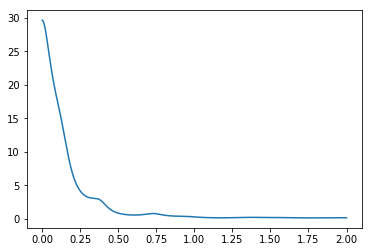

In [20]:
# apply a Tool
frequencies, power = compute_psd(ibi.resample(4))

plt.plot(frequencies, power)
plt.show()